In [1]:
import sys

import numpy as np

sys.path.append("/home/cyprien/Documents/github/pytorch-forecasting")
sys.path.append("../")

import hashlib

from data_factory.preprocessing import *
from utilities.config import load_config

from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

import seaborn as sns
sns.set_style('darkgrid')

tqdm.pandas()

In [2]:
config_file = '../config/config.yml'
use_previous_files = False
export = False

In [3]:
config = load_config(config_file)

model = config['model']
model_config = config[model]

# Create variables from config
#  data loading
save_folder = config['data']['save']
train_file = config['data']['train_path'] + config['data']['stock_prices']
test_file = config['data']['test_path'] + config['data']['stock_prices']

#  TimeSeries settings
max_prediction_length = model_config['sliding_window']['max_prediction_length']
min_prediction_length = model_config['sliding_window']['min_prediction_length']
max_encoder_length = model_config['sliding_window']['max_encoder_length']
min_encoder_length = model_config['sliding_window']['min_encoder_length']
batch_size = model_config['sliding_window']['batch_size']

related_stocks = model_config['related_stock']
train_val_split = model_config['train_val_split']
scale = model_config['manual_scale']

# define file name for saving StockPricesLoader with specific config
hash_ = hashlib.md5(model_config.__str__().encode('utf-8')).hexdigest()
export_file_name = f"{save_folder}/export_{hash_}.p"

print(f'Export file {export_file_name}')
print(f'Use config {config}')


Export file ../data/save//export_33330b8610da212bf1f1161f2e2ce8c7.p
Use config {'device': 'cpu', 'seed': False, 'model': 'temporal_fusion_transformer', 'data': {'save': '../data/save/', 'suppl': '../data/suppl/', 'train_path': '../data/jpx-tokyo-stock-exchange-prediction/train_files/', 'test_path': '../data/jpx-tokyo-stock-exchange-prediction/supplemental_files/', 'financials': 'financials.csv', 'stock_prices': 'stock_prices.csv', 'options': 'options.csv', 'secondary_stock_price': 'secondary_stock_prices.csv', 'trades': 'trades.csv', 'cosine': 'cosine_df.csv'}, 'rnn': {'sliding_window': {'max_prediction_length': 10, 'min_prediction_length': 10, 'max_encoder_length': 80, 'min_encoder_length': 80, 'batch_size': 64}, 'train_val_split': 1, 'related_stock': 2, 'manual_scale': True, 'hidden_size': 20, 'layers': 3, 'dropout': 0}, 'temporal_fusion_transformer': {'sliding_window': {'max_prediction_length': 5, 'min_prediction_length': 5, 'max_encoder_length': 150, 'min_encoder_length': 150, 'bat

### Load

In [58]:
from data_factory.prepared_data import PreparedData

data: PreparedData = PreparedData.from_file("../data/save/preprocessed_data.pkl")
df_train = data.train.copy()
df_val = data.val.copy()
df_test = data.test.copy()

df_val = df_val.groupby('SecuritiesCode').progress_apply(lambda x: x.loc[x.Date > df_train.loc[df_train.SecuritiesCode == x.name, 'Date'].max()]).reset_index(drop=True)
df_test = df_test.groupby('SecuritiesCode').progress_apply(lambda x: x.loc[x.Date > df_val.loc[df_val.SecuritiesCode == x.name, 'Date'].max()]).reset_index(drop=True)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

#### Indicators

In [69]:
def create_examples():
    sc_ex = df_test.SecuritiesCode.unique()[0]
    dft_sx = df_train[df_train.SecuritiesCode == sc_ex].copy()
    dfv_sx = df_val[df_val.SecuritiesCode == sc_ex].copy()
    dfe_sx = df_test[df_test.SecuritiesCode == sc_ex].copy()

    dft_sx.reset_index(drop=True, inplace=True)
    dfv_sx.reset_index(drop=True, inplace=True)
    dfe_sx.reset_index(drop=True, inplace=True)

    dfv_sx['idx'] = dfv_sx.index + dft_sx.index.max()
    dfe_sx['idx'] = dfe_sx.index + dfv_sx.idx.max()
    dfv_sx.set_index('idx', inplace=True)
    dfe_sx.set_index('idx', inplace=True)
    return sc_ex, dft_sx, dfv_sx, dfe_sx
sc_ex, dft_sx, dfv_sx, dfe_sx = create_examples()

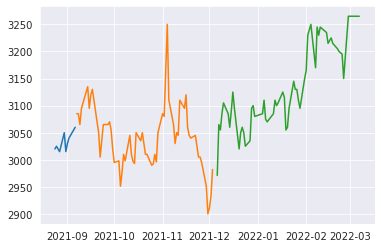

In [70]:
plt.plot(dft_sx.Date.iloc[-10:], dft_sx.Close.iloc[-10:])
plt.plot(dfv_sx.Date,dfv_sx.Close)
plt.plot(dfe_sx.Date,dfe_sx.Close)

In [71]:
def plot_indicators(df: pd.DataFrame, col: str, sc=sc_ex, span=30):
    df_ = df[df.SecuritiesCode == sc]
    fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(15, 7), gridspec_kw={'height_ratios': [3, 1], 'hspace':.03})

    axs[0].plot(df_.Date, df_[col], label="price")
    axs[0].plot(df_.Date, df_[f'{col}_SMA{span}'], label="moving average")
    axs[0].plot(df_.Date, df_[f'{col}_CMA{span}'], label="cumulative moving average")
    axs[0].plot(df_.Date, df_[f'{col}_EWMA{span}'], label="exponentially weighted moving average")
    axs[1].plot(df_.Date, df_[f'{col}_STD{span}'], label="standard derivation")

    axs[0].legend()
    axs[1].legend()

def dickey_fuller_test(s: pd.Series):
    result = adfuller(s)
    print(f'ADF Statistics {result[0]}')
    print(f'p-value {result[1]}')
    print(f'Critical values')
    for key, value in result[4].items():
        print(f"\t{key}: {value}")

def indicators(df: pd.DataFrame, col: str, *, sc=sc_ex, span=30):
    df[f'{col}_SMA{span}'] = df.groupby('SecuritiesCode')[col].rolling(span).mean().reset_index(drop=True)  # simple moving average
    df[f'{col}_STD{span}'] = df.groupby('SecuritiesCode')[col].rolling(span).std().reset_index(drop=True)  # standard derivation
    df[f'{col}_CMA{span}'] = df.groupby('SecuritiesCode')[col].expanding().mean().reset_index(drop=True)  # cumulative moving average
    df[f'{col}_EWMA{span}'] = df.groupby('SecuritiesCode')[col].ewm(span=span).mean().reset_index(drop=True)  # exponentially weighted moving average

    plot_indicators(df, col, sc, span)
    dickey_fuller_test(df[df.SecuritiesCode == sc][col])

#### Price analysis

ADF Statistics -1.9560258263013892
p-value 0.30618062680032443
Critical values
	1%: -3.435550533536195
	5%: -2.863836575823745
	10%: -2.567992721718317


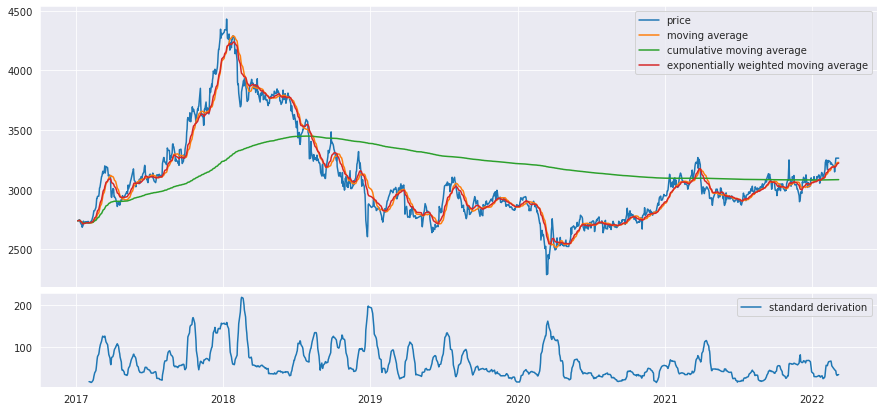

In [72]:
df_train['type'] = 'train'
df_val['type'] = 'val'
df_test['type'] = 'test'

df_total = pd.concat([df_train, df_val, df_test])
df_total.sort_values(by=['SecuritiesCode', 'Date'], inplace=True)
df_total.reset_index(drop=True, inplace=True)

span = 20
col = f'Close_EWMA{span}'
indicators(df_total, 'Close', span=span)

df_train = df_total[df_total.type == 'train'].copy()
df_val = df_total[df_total.type == 'val'].copy()
df_test = df_total[df_total.type == 'test'].copy()

del df_total

#### Price minus moving average analysis

ADF Statistics -7.34928148098321
p-value 1.0160075649177942e-10
Critical values
	1%: -3.4361245824564977
	5%: -2.8640898339013243
	10%: -2.56812759902191


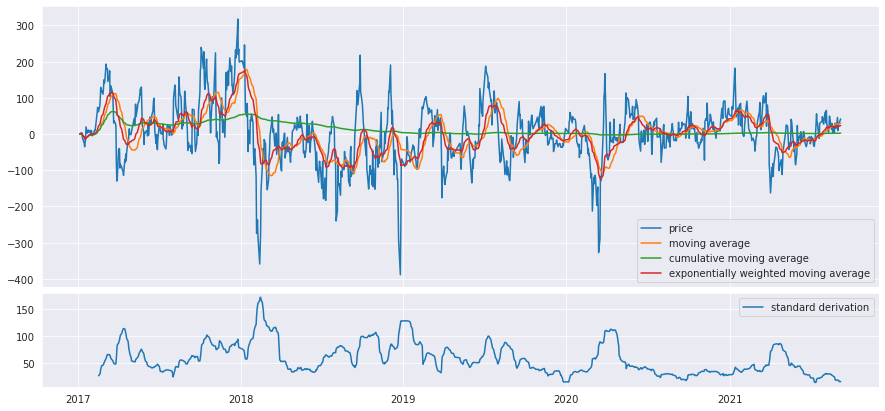

In [73]:
df_train[f'Close_minus_SMA{span}'] = df_train.Close - df_train[col]
df_train_filtered = df_train[[f'Close_minus_SMA{span}', 'SecuritiesCode', 'Date']].copy()
df_train_filtered.dropna(subset=[f'Close_minus_SMA{span}'], inplace=True)

indicators(df_train_filtered, f'Close_minus_SMA{span}')


Moving average and std are approximately horizontal. p-value is above .05 and ADF statistic is close to critical values. Therefore the timeseries is stationary

## ARIMA Model

In [74]:
sc_ex, dft_sx, dfv_sx, dfe_sx = create_examples()

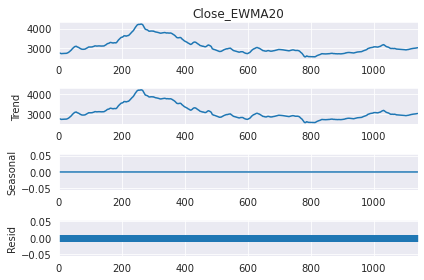

In [75]:
f = dft_sx[col].notnull()
decomposition = seasonal_decompose(dft_sx[f][col], period=1, model='additive')
p = decomposition.plot()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6270.917, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8142.831, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6269.182, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7216.913, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8141.745, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6270.944, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6272.412, Time=0.37 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=6267.259, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=6269.023, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=6268.996, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=7215.622, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=6270.491, Time=0.14 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.229 seconds
1140 1200 (60,)


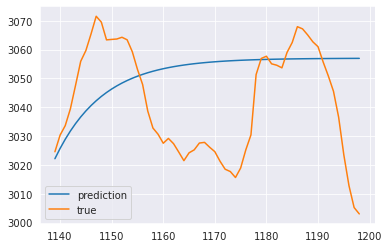

In [76]:
from pmdarima import auto_arima

stepwise_fit: ARIMA = auto_arima(
    dft_sx[f][col],
    start_p=1, start_q=1,
    max_p=50, max_q=50, seasonal=False,
    d=None, D=1,
    trace=True, error_action='ignore',
    supress_warnings=False,
    stepwise=True
)
stepwise_fit.summary()

start = len(dft_sx)
end = len(dft_sx) + len(dfv_sx)
predictions = stepwise_fit.predict(end - start)
print(start, end, predictions.shape)
plt.plot(dfv_sx.index, predictions, label='prediction')
plt.plot(dfv_sx[col], label='true')
plt.legend()

/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


CPU times: user 1.5 s, sys: 32 ms, total: 1.53 s
Wall time: 259 ms


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Close_EWMA20   No. Observations:                 1140
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -3131.246
Date:                Fri, 17 Jun 2022   AIC                           6270.491
Time:                        16:57:27   BIC                           6290.643
Sample:                             0   HQIC                          6278.102
                               - 1140                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5294      0.861      0.615      0.539      -1.159       2.218
ar.L2          0.3266      0.776      0.421      0.674      -1.194       1.848
ma.L1          0.3905      0.854      0.457      0.648      -1.284       2.065
sigma2        14.2810      0.409     34.897      0.000      13.479      15.083
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):               279.24
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               0.68   Skew:                            -0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

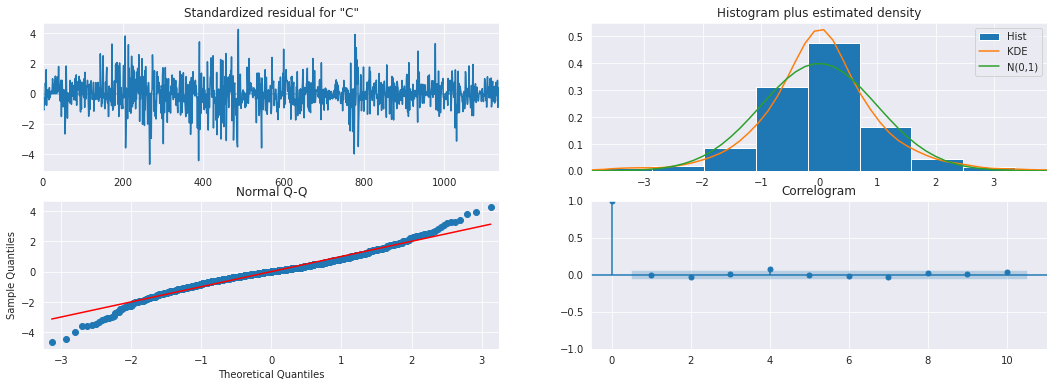

In [77]:
%%time

model = ARIMA(dft_sx[col], order=(2, 1, 1))  # 50 1 3 did ok
results = model.fit()

results.plot_diagnostics(figsize=(18, 6))
results.summary()

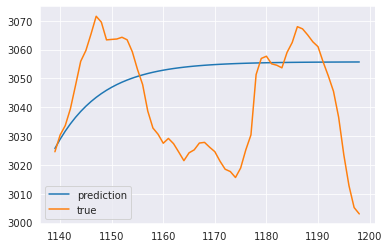

In [78]:
start = len(dft_sx)
end = start + len(dfv_sx)
predictions = results.predict(start+1, end)

plt.plot(dfv_sx.index, predictions, label='prediction')
plt.plot(dfv_sx.index, dfv_sx[col], label='true')
plt.legend()

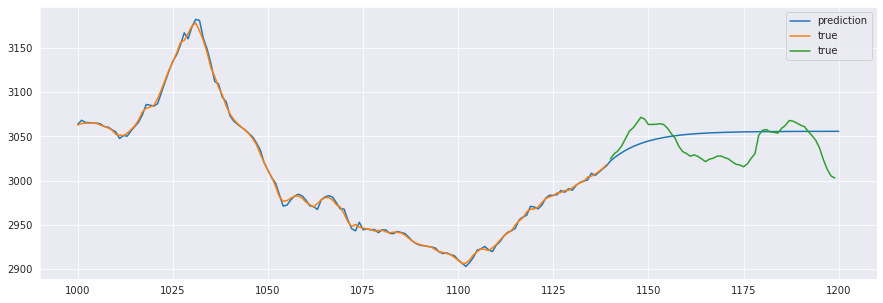

In [79]:
start = 1000
end = 1200
predictions = results.predict(start, end, dynamic=140)
plt.figure(figsize=(15, 5))
plt.plot(predictions, label='prediction')
plt.plot(dft_sx.index[start: end], dft_sx[col][start: end], label='true')
plt.plot(list(range(len(dft_sx), end)), dfv_sx[col][0: end-len(dft_sx)], label='true')
plt.legend()

### Forecasting

### Train of each SecuritiesCode

In [80]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [87]:
from IPython.core.display_functions import display

from utilities.evaluation import calc_spread_return_sharpe

k = 2

def eval(df_f: pd.DataFrame):
    df_ = df_f.dropna(subset=['Target_pred'])

    tp = ((df_.Target > 0) == (df_.Target_pred > 0)).sum()
    fp = ((df_.Target <= 0) == (df_.Target_pred > 0)).sum()
    tn = ((df_.Target <= 0) == (df_.Target_pred <= 0)).sum()
    fn = ((df_.Target > 0) == (df_.Target_pred <= 0)).sum()

    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    f1 = 2 * (precision * recall) / (precision + recall)
    return pd.DataFrame([dict(
        tp=tp,
        tn=tn,
        fp=fp,
        fn=fn,
        f1= f1,
        precision=precision,
        recall=recall,
        sharpe= np.nan,
        money_gained= df_.loc[df_.Rank < 200].Target.sum() - df_.loc[df_.Rank >= 1800].Target.sum(),
        true_positive= ((df_.loc[df_.Rank < 200].Target > 0).sum(), (df_.loc[df_.Rank >= 1800].Target <= 0).sum()),
        false_positive= ((df_.loc[df_.Rank < 200].Target <= 0).sum(), (df_.loc[df_.Rank >= 1800].Target > 0).sum()),
        true_positive_sum= (df_.loc[df_.Rank < 200].Target > 0).sum() + (df_.loc[df_.Rank >= 1800].Target <= 0).sum(),
        false_positive_sum= (df_.loc[df_.Rank < 200].Target <= 0).sum() + (df_.loc[df_.Rank >= 1800].Target > 0).sum(),
    )])

def forecast_on_sc(col, df_: pd.DataFrame, df_train_subset:pd.DataFrame, df_val_subset:pd.DataFrame, model_, type_: str = 'train', plot: bool = False):
    df_.set_index('idx', inplace=True)
    forecasts_ = []

    if type_ == 'test':
        model_ = model_.append(df_val_subset.loc[df_val_subset.SecuritiesCode == df_.name, col], refit=False)

    if type_ != 'train':
        model_ = model_.append(df_[col], refit=False)

    for i in df_.index:
        forecasts_.append(model_.predict(start=i, end=i+k-1, dynamic=0))

    forecasts_1 = pd.Series([e[0] for e in forecasts_],  index=df_.index)
    df_[f'{col}_pred'] = forecasts_1
    df_['Target_pred'] = pd.Series([((e[1] - e[0]) / e[0]) for e in forecasts_],  index=df_.index)

    dft_tc = df_train_subset[df_train_subset.SecuritiesCode == df_.name].copy()
    dfv_tc = df_val_subset[df_val_subset.SecuritiesCode == df_.name].copy()
    dft_tc.set_index('idx', inplace=True)
    dfv_tc.set_index('idx', inplace=True)

    start = max(df_.index.min() - 50, 1)
    end = df_.index.max()

    if plot:
        plt.figure(figsize=(15, 3))
        plt.plot(df_.loc[start:end, 'Date'], forecasts_1.loc[start:end], label='prediction')

        if type_ == 'val':
            plt.plot(dft_tc.loc[start:, 'Date'], dft_tc.loc[start:, col], label='true train set')
            plt.plot(dft_tc.loc[start:, 'Date'], dft_tc.loc[start:, 'Close'], '--', label='Close')
        if type_ == 'test':
            plt.plot(dfv_tc.loc[start:, 'Date'], dfv_tc.loc[start:, col], label='true val set')
            plt.plot(dfv_tc.loc[start:, 'Date'], dfv_tc.loc[start:, 'Close'], '--', label='Close')
        plt.plot(df_.loc[:end, 'Date'], df_.loc[:end, col], label='true')
        plt.plot(df_.loc[:end, 'Date'], df_.loc[:end, 'Close'], '--', label='Close')
        plt.legend()
        plt.show()
    return df_.reset_index(drop=False)


def fit(col, number_of_sc:int = 20, orders=[(10, 1, 3)], gs_results=pd.DataFrame()):
    # Fitting
    scs = df_train.SecuritiesCode.unique()[:number_of_sc]

    # Prepare test set
    df_train_subset = df_train.loc[df_train.SecuritiesCode.isin(scs)].copy()
    df_train_subset.reset_index(drop=True, inplace=True)
    df_train_subset.loc[:, 'idx'] = df_train_subset.index
    df_train_subset['idx'] = df_train_subset.groupby('SecuritiesCode').apply(lambda x: pd.Series(x.idx - x.idx.min())).reset_index(drop=True)

    for order in orders:
        print(order)
        ARIMAs = df_train_subset.groupby('SecuritiesCode')[col].progress_apply(lambda x: ARIMA(x.to_numpy(), order=order).fit()).to_frame('model')

    # Prepare val set
    df_val_subset = df_val.loc[df_val.SecuritiesCode.isin(scs)].copy()
    df_val_subset.reset_index(drop=True, inplace=True)
    df_val_subset.loc[:, 'idx'] = df_val_subset.index
    df_val_subset['idx'] = df_val_subset.groupby('SecuritiesCode').apply(lambda x: pd.Series(x.idx - x.idx.min()) + len(df_train[df_train.SecuritiesCode == x.name])).reset_index(drop=True)

    # Prepare test set
    df_test_subset = df_test.loc[df_test.SecuritiesCode.isin(scs)].copy()
    df_test_subset.reset_index(drop=True, inplace=True)
    df_test_subset.loc[:, 'idx'] = df_test_subset.index
    df_test_subset['idx'] = df_test_subset.groupby('SecuritiesCode').apply(lambda x: pd.Series(x.idx - x.idx.min()) + len(df_train[df_train.SecuritiesCode == x.name]) + len(df_val[df_val.SecuritiesCode == x.name])).reset_index(drop=True)


    # Test
    for order in orders:
        # Eval on train set
        # df_train_subset = df_train_subset.groupby('SecuritiesCode').progress_apply(lambda x: forecast_on_sc(col, x, df_train_subset, df_val_subset, ARIMAs.loc[x.name][0], type_='train')).reset_index(drop=True)
        # df_train_subset[f'{col}_pred_{order}'] = df_train_subset[f'{col}_pred']
        # df_train_subset[f'Target_pred_{order}'] = df_train_subset.Target_pred
        #
        # ev = eval(df_train_subset)
        # ev['config'] = str(order)
        # ev['mode'] = 'train'
        # gs_results = pd.concat([gs_results, ev])
        # print(gs_results)
        #
        # # Eval on val set
        # df_val_subset = df_val_subset.groupby('SecuritiesCode').progress_apply(lambda x: forecast_on_sc(col, x, df_train_subset, df_val_subset, ARIMAs.loc[x.name][0], type_='val')).reset_index(drop=True)
        # df_val_subset[f'{col}_pred_{order}'] = df_val_subset[f'{col}_pred']
        # df_val_subset[f'Target_pred_{order}'] = df_val_subset.Target_pred
        #
        # ev = eval(df_val_subset)
        # ev['config'] = str(order)
        # ev['mode'] = 'val'
        # gs_results = pd.concat([gs_results, ev])
        # print(gs_results)

        # Test on test set
        df_test_subset = df_test_subset.groupby('SecuritiesCode').progress_apply(lambda x: forecast_on_sc(col, x, df_test_subset, df_val_subset, ARIMAs.loc[x.name][0], type_='test')).reset_index(drop=True)
        df_test_subset[f'{col}_pred_{order}'] = df_test_subset[f'{col}_pred']
        df_test_subset[f'Target_pred_{order}'] = df_test_subset.Target_pred

        df_ = df_test_subset.copy()
        df_['Rank'] = (df_.groupby("Date")["Target_pred"].rank(ascending=False, method="first") - 1).astype(int)
        # return df_
        # print(df_.Target_pred)

        ev = eval(df_)
        ev['config'] = str(order)
        ev['mode'] = 'test'
        ev['sharpe'] = calc_spread_return_sharpe(df_[df_.is_testing == True])
        gs_results = pd.concat([gs_results, ev])

        print(gs_results)

    return gs_results

In [88]:
results = fit(col, number_of_sc=2000, orders=[(2, 1, 1)])

(2, 1, 1)


  0%|          | 0/2000 [00:00<?, ?it/s]

/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


  0%|          | 0/2000 [00:00<?, ?it/s]

      tp     tn     fp     fn        f1  precision    recall    sharpe  \
0  61600  61600  60400  60400  0.504918   0.504918  0.504918  0.119989   

   money_gained true_positive false_positive  true_positive_sum  \
0      33.34116  (5557, 7084)   (6643, 5116)              12641   

   false_positive_sum     config  mode  
0               11759  (2, 1, 1)  test  


In [89]:
results

,tp,tn,fp,fn,f1,precision,recall,sharpe,money_gained,true_positive,false_positive,true_positive_sum,false_positive_sum,config,mode
0,61600,61600,60400,60400,0.504918,0.504918,0.504918,0.119989,33.34116,"(5557, 7084)","(6643, 5116)",12641,11759,"(2, 1, 1)",test


In [90]:
gs_results = fit(col, number_of_sc=2000, orders=[(3, 1, 1)], gs_results=results)

(3, 1, 1)


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

      tp     tn     fp     fn        f1  precision    recall    sharpe  \
0  61600  61600  60400  60400  0.504918   0.504918  0.504918  0.119989   
0  61643  61643  60357  60357  0.505270   0.505270  0.505270  0.118320   

   money_gained true_positive false_positive  true_positive_sum  \
0     33.341160  (5557, 7084)   (6643, 5116)              12641   
0     32.451765  (5552, 7086)   (6648, 5114)              12638   

   false_positive_sum     config  mode  
0               11759  (2, 1, 1)  test  
0               11762  (3, 1, 1)  test  


In [91]:
gs_results

,tp,tn,fp,fn,f1,precision,recall,sharpe,money_gained,true_positive,false_positive,true_positive_sum,false_positive_sum,config,mode
0,61600,61600,60400,60400,0.504918,0.504918,0.504918,0.119989,33.341160,"(5557, 7084)","(6643, 5116)",12641,11759,"(2, 1, 1)",test
0,61643,61643,60357,60357,0.505270,0.505270,0.505270,0.118320,32.451765,"(5552, 7086)","(6648, 5114)",12638,11762,"(3, 1, 1)",test


In [92]:
gs_results = fit('Close', number_of_sc=2000, orders=[(2, 1, 1)], gs_results=results)

(2, 1, 1)


  0%|          | 0/2000 [00:00<?, ?it/s]

/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/cyprien/anaconda3/envs/pytorch/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


  0%|          | 0/2000 [00:00<?, ?it/s]

      tp     tn     fp     fn        f1  precision    recall    sharpe  \
0  61600  61600  60400  60400  0.504918   0.504918  0.504918  0.119989   
0  61155  61155  60845  60845  0.501270   0.501270  0.501270 -0.004151   

   money_gained true_positive false_positive  true_positive_sum  \
0     33.341160  (5557, 7084)   (6643, 5116)              12641   
0      0.944047  (5312, 6976)   (6888, 5224)              12288   

   false_positive_sum     config  mode  
0               11759  (2, 1, 1)  test  
0               12112  (2, 1, 1)  test  


In [93]:
gs_results

,tp,tn,fp,fn,f1,precision,recall,sharpe,money_gained,true_positive,false_positive,true_positive_sum,false_positive_sum,config,mode
0,61600,61600,60400,60400,0.504918,0.504918,0.504918,0.119989,33.341160,"(5557, 7084)","(6643, 5116)",12641,11759,"(2, 1, 1)",test
0,61155,61155,60845,60845,0.501270,0.501270,0.501270,-0.004151,0.944047,"(5312, 6976)","(6888, 5224)",12288,12112,"(2, 1, 1)",test
